# Top 50 Spotify EDA and Predicting Popularity

In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

## Read in data

In [3]:
top50_df = pd.read_csv('top50.csv', index_col=0)
top50_df.head()

,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


### Let's rename the columns

In [4]:
top50_df.columns = top50_df.columns.str.replace('.', ' ').str.strip(' ')
top50_df.columns = top50_df.columns.str.replace(' ', '_')
top50_df.columns = top50_df.columns.str.replace('__', '_')
top50_df.head()

<ipython-input-4-4f5de4eecc43>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  top50_df.columns = top50_df.columns.str.replace('.', ' ').str.strip(' ')


,Track_Name,Artist_Name,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


## 1. EDA

### Let's explore our data types

In [5]:
top50_df.dtypes

Track_Name          object
Artist_Name         object
Genre               object
Beats_Per_Minute     int64
Energy               int64
Danceability         int64
Loudness_dB          int64
Liveness             int64
Valence              int64
Length               int64
Acousticness         int64
Speechiness          int64
Popularity           int64
dtype: object

We know that python handles NaNs by converting integer values to float values. Since our datatypes do not contain any floats, it is unlikely that we have any NaNs at least for the integer columns. Still, let's check just in case.

### Check for NaNs

In [6]:
top50_df.isna().any()

Track_Name          False
Artist_Name         False
Genre               False
Beats_Per_Minute    False
Energy              False
Danceability        False
Loudness_dB         False
Liveness            False
Valence             False
Length              False
Acousticness        False
Speechiness         False
Popularity          False
dtype: bool

We find that we do not have any NaNs.

### Check for unusual values

When we examine track names, we notice an unusual value for row 33. Let's explore further.

In [7]:
top50_df.iloc[32,:]

Track_Name          0.958333333
Artist_Name              Maluma
Genre                 reggaeton
Beats_Per_Minute             96
Energy                       71
Danceability                 78
Loudness_dB                  -5
Liveness                      9
Valence                      68
Length                      176
Acousticness                 22
Speechiness                  28
Popularity                   89
Name: 33, dtype: object

The track name seems unusual. The artist name is Maluma, and after a quick search to see if the artist just has an eclectic taste in song names, we find that the track name is indeed incorrect. Next we check to see if there may be an error in the .csv formatting causing a misalignment in data values for pandas.

In [8]:
! grep Maluma top50.csv

33,0.958333333,Maluma,reggaeton,96,71,78,-5,9,68,176,22,28,89


This looks fine as well. Since information about this artist's top hits is readily available to us, we can find the correct song name and update the table values. A quick search reveals a song called <b> 'Perfecta' </b> which was part of the top 50, with a song length of ~176 seconds. A quick listen also confirms that the genre and liveliness seem to match as well. We may update the value.

In [9]:
top50_df.at[33, 'Track_Name'] = 'Perfecta'

### Now that we've checked track names for errors, let's see if we can draw any additional insights based on song names. 

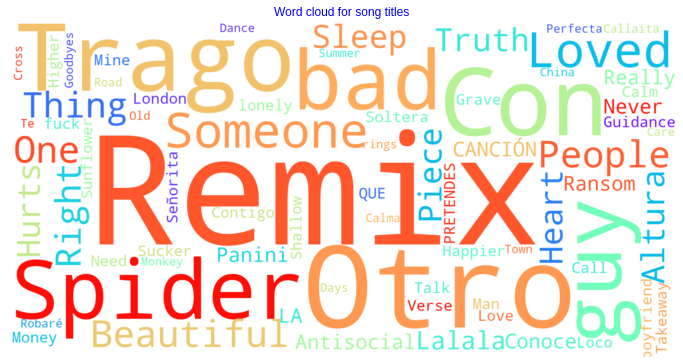

In [10]:
plt.style.use('seaborn')
wrds1 = top50_df["Track_Name"].str.split("(").str[0].value_counts().keys()

wc1 = WordCloud(scale=5,max_words=1000,colormap="rainbow",background_color="white").generate(" ".join(wrds1))
plt.figure(figsize=(12,18))
plt.imshow(wc1,interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for song titles",color='b')
plt.show()

We notice Remix pops up often. Interestingly, many of the words that appear most frequently appear to be negative in tone:
- Con
- Bad
- Hurts
- lonely

We have another grouping that is likely related to love songs:
- Heart
- Love / Loved
- Need
- Beautiful

Because the track names are all unique, including them in the model will likely result in overfitting. Instead, we can focus on a couple of aspects that may be of interest to see if including some information about track name may be beneficial for the model.

In [11]:
remix = [top50_df[top50_df['Track_Name'].str.contains('Remix')].Popularity.median(),
         top50_df[~top50_df["Track_Name"].str.contains('Remix')].Popularity.median()]

collab_tags = ['feat', 'Feat', 'with', 'With']
pattern = '|'.join(collab_tags)
collab = [top50_df[top50_df['Track_Name'].str.contains(pattern)].Popularity.median(),
         top50_df[~top50_df['Track_Name'].str.contains(pattern)].Popularity.median()]

love_tags = ['Heart', 'Love', 'Loved', 'Need', 'Beautiful']
pattern = '|'.join(love_tags)
love = [top50_df[top50_df['Track_Name'].str.contains(pattern)].Popularity.median(),
         top50_df[~top50_df['Track_Name'].str.contains(pattern)].Popularity.median()]

sad_tags = ['Con', 'Bad', 'Hurts', 'lonely']
pattern = '|'.join(sad_tags)
sad = [top50_df[top50_df['Track_Name'].str.contains(pattern)].Popularity.median(),
         top50_df[~top50_df['Track_Name'].str.contains(pattern)].Popularity.median()]

In [12]:
track_df = pd.DataFrame(['Remix', 'Collab', 'Love', 'Sad'], columns=['Type'])
track_df.join(pd.DataFrame([remix, collab, love, sad], columns=['Contains', 'Does Not Contain']))

,Type,Contains,Does Not Contain
0,Remix,87.0,88.5
1,Collab,86.0,89.0
2,Love,88.0,88.0
3,Sad,87.0,88.5


After looking at the different song titles, it does not seem like any of the groupings contribute significantly to differences in popularity score. We may leave song titles out of our model. Next, let's look at artist name.

In [13]:
top50_df.groupby(['Artist_Name'])['Popularity'].unique().reset_index().sort_values(by = 'Artist_Name')

,Artist_Name,Popularity
0,Ali Gatie,[89]
1,Anuel AA,[92]
2,Ariana Grande,"[85, 89]"
3,Bad Bunny,[93]
4,Billie Eilish,"[95, 89]"
5,Chris Brown,[82]
6,DJ Snake,[86]
7,Daddy Yankee,[91]
8,Drake,[92]
9,Ed Sheeran,"[86, 84, 87, 82]"


There are no unusual data points above. Notice that most artists only appear in the top 50 once. There are a handful that appear more often:
- Ed Sheeran
- Ariana Grande
- Billie Eilish	
- J Balvin
- Lil Nas X
- Post Malone
- Sech
- Shawn Mendes
- The Chainsmokers

But we don't notice anything unusual about their values with the exception of Shawn Mendes, who appears to rank lower in popularity than the other artists. 

### Next, we look at genres. 

Since we have some repeated genres, we can check this column for unusual values and also look at which genres tend to fall in the top 50. 

In [14]:
top50_df[['Genre']].value_counts()

Genre           
dance pop           8
pop                 7
latin               5
edm                 3
canadian hip hop    3
reggaeton flow      2
reggaeton           2
brostep             2
canadian pop        2
country rap         2
dfw rap             2
electropop          2
panamanian pop      2
r&b en espanol      1
pop house           1
atl hip hop         1
escape room         1
australian pop      1
boy band            1
big room            1
trap music          1
dtype: int64

There are no unusual values here. There are a lot of songs here that are a variant of pop (which is not unusual for top hits). 

The remaining variables are continuous, so we can look at the distribution of values using violin plots to see if we notice anything unusual.

Earlier, we may have noticed that all of the continuous variables appear to be on very different scales. This will make looking at their distributions side-by-side difficult to compare. We can scale our data to remedy this problem. We will use a Min Max Scaler.

In [15]:
# Scale our data

scaler = MinMaxScaler()
scaler.fit(top50_df.iloc[:,3:])
scaled_data = scaler.transform(top50_df.iloc[:,3:])
scaled_top50_df = pd.DataFrame(scaled_data, columns=top50_df.iloc[:,3:].columns)

scaled_top50_df = pd.concat([top50_df.iloc[:,0:3].reset_index(),scaled_top50_df], axis = 1 )
scaled_top50_df.drop(['index'], axis = 1, inplace = True) # remove extra index column that has been added
scaled_top50_df.head()

,Track_Name,Artist_Name,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,Señorita,Shawn Mendes,canadian pop,0.304762,0.410714,0.770492,0.555556,0.056604,0.764706,0.391753,0.040541,0.000000,0.36
1,China,Anuel AA,reggaeton flow,0.190476,0.875000,0.819672,0.777778,0.056604,0.600000,0.963918,0.094595,0.139535,0.88
2,boyfriend (with Social House),Ariana Grande,dance pop,1.000000,0.857143,0.180328,0.777778,0.207547,0.705882,0.365979,0.148649,1.000000,0.60
3,Beautiful People (feat. Khalid),Ed Sheeran,pop,0.076190,0.589286,0.573770,0.333333,0.056604,0.529412,0.427835,0.148649,0.372093,0.64
4,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,0.619048,0.589286,0.475410,0.777778,0.113208,0.094118,0.309278,0.594595,0.093023,0.96


<AxesSubplot:>

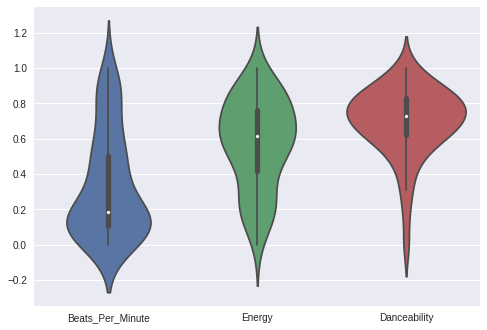

In [16]:
sns.violinplot(data=scaled_top50_df.iloc[:,3:6])

<AxesSubplot:>

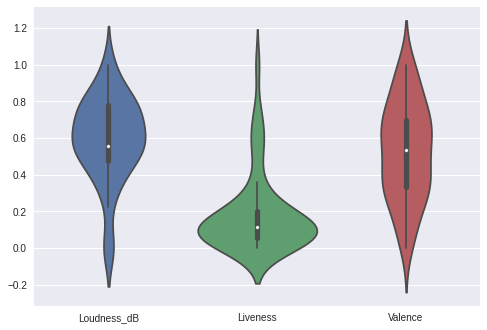

In [17]:
sns.violinplot(data=scaled_top50_df.iloc[:,6:9])

<AxesSubplot:>

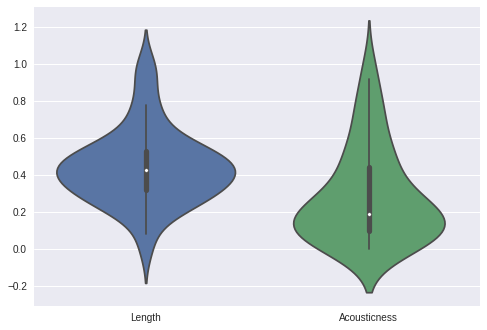

In [18]:
sns.violinplot(data=scaled_top50_df.iloc[:,9:-2])

No unusual values here

### Let's look at the popularity score across a given genre

In [19]:
tmp_df = top50_df[['Popularity', 'Genre']].copy()
tmp_bins = tmp_df.Genre.value_counts()
tmp_bins = tmp_bins[tmp_bins>1].index
tmp_df['Bins'] = tmp_df.Genre.apply(lambda x: x if x in tmp_bins else 'other')

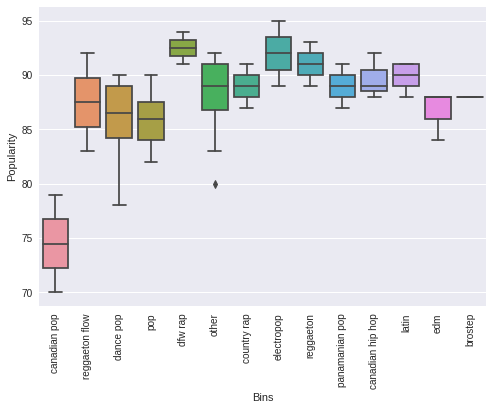

In [20]:
plot = sns.boxplot(y='Popularity', x='Bins', data=tmp_df)
_ = plt.setp(plot.get_xticklabels(), rotation=90)

We see that there are variations between popularity scores across genres. We want to include this information in our model, however certain genres only have a single track in the top 50. If we were to dummify the variables then our model will most likely overfit. Instead, let's see if we can use clustering on certain track features to determine hidden groups (and possibly find a way to include genre without overfitting). 

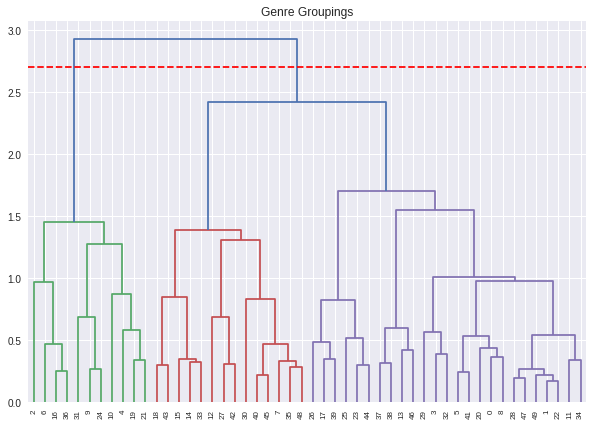

In [21]:
plt.figure(figsize=(10, 7))  
plt.title("Genre Groupings")  
dend = shc.dendrogram(shc.linkage(scaled_top50_df[['Beats_Per_Minute', 'Energy', 'Danceability', 'Valence', 'Acousticness', 'Speechiness']], method='ward'))
plt.axhline(y=2.7, color='r', linestyle='--')

In [22]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled_top50_df[['Beats_Per_Minute', 'Energy', 'Danceability', 'Valence', 'Acousticness', 'Speechiness']])

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [23]:
scaled_top50_df['clustered_genre'] = cluster.fit_predict(scaled_top50_df[['Beats_Per_Minute', 'Energy', 'Danceability', 'Valence', 'Acousticness', 'Speechiness']])

In [24]:
scaled_top50_df.groupby('clustered_genre')['Genre'].value_counts()

clustered_genre  Genre           
0                pop                 7
                 dance pop           6
                 latin               4
                 canadian hip hop    3
                 edm                 3
                 brostep             2
                 canadian pop        2
                 reggaeton flow      2
                 atl hip hop         1
                 australian pop      1
                 big room            1
                 boy band            1
                 country rap         1
                 dfw rap             1
                 panamanian pop      1
                 pop house           1
                 r&b en espanol      1
                 reggaeton           1
1                dance pop           2
                 electropop          2
                 country rap         1
                 dfw rap             1
                 escape room         1
                 latin               1
                 panamanian po

### Let's see if our new clusters map to any particular groups of the original genres. 
We see that based off of the given track features, there really isn't a separation between the genres. But let's see if these new clusters provide any additional information.

In [25]:
genre_by_cluster = scaled_top50_df[['Popularity', 'clustered_genre']].groupby('clustered_genre')['Popularity'].mean()
for idx in range(0,len(genre_by_cluster)):
    try: 
        print(idx, genre_by_cluster[idx])
    except:
        continue

0 0.6615384615384612
1 0.8363636363636363


In [26]:
scaled_top50_df.groupby('clustered_genre')['Popularity'].median()

clustered_genre
0    0.72
1    0.84
Name: Popularity, dtype: float64

There appears to be a sizeable difference in popularity scores between the two clusters. Let's examine which features make them differ:

<AxesSubplot:xlabel='clustered_genre', ylabel='Beats_Per_Minute'>

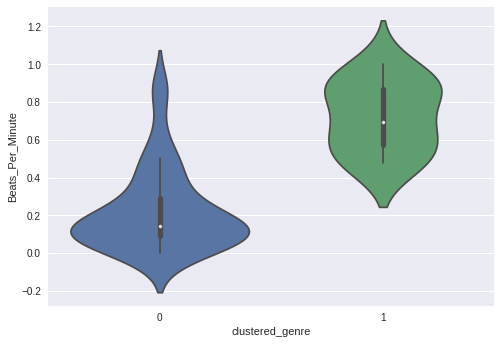

In [27]:
sns.violinplot(data=scaled_top50_df, y= 'Beats_Per_Minute', x ='clustered_genre')

<AxesSubplot:xlabel='clustered_genre', ylabel='Valence'>

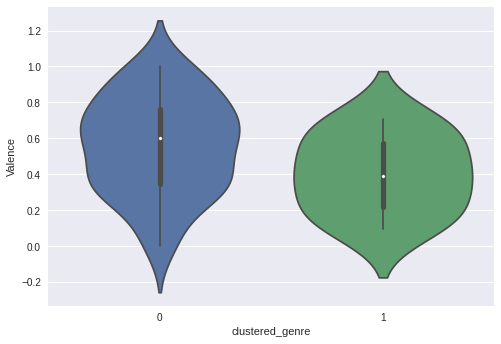

In [28]:
sns.violinplot(data=scaled_top50_df, y= 'Valence', x ='clustered_genre')

<AxesSubplot:xlabel='clustered_genre', ylabel='Length'>

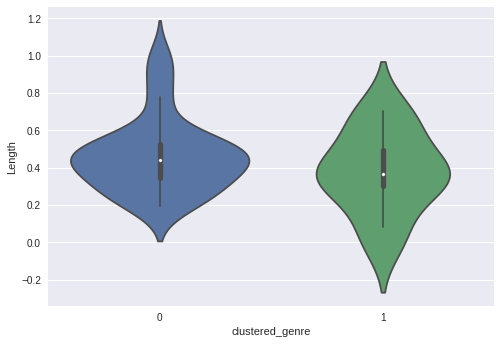

In [29]:
sns.violinplot(data=scaled_top50_df, y= 'Length', x ='clustered_genre')

<AxesSubplot:xlabel='clustered_genre', ylabel='Acousticness'>

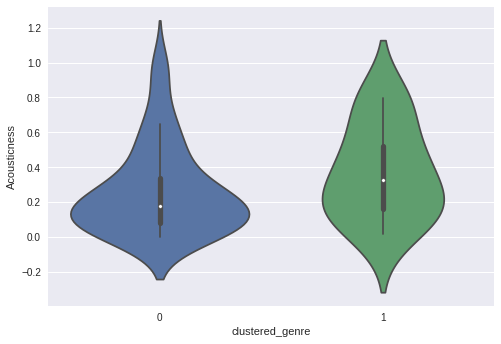

In [30]:
sns.violinplot(data=scaled_top50_df, y= 'Acousticness', x ='clustered_genre')

<AxesSubplot:xlabel='clustered_genre', ylabel='Speechiness'>

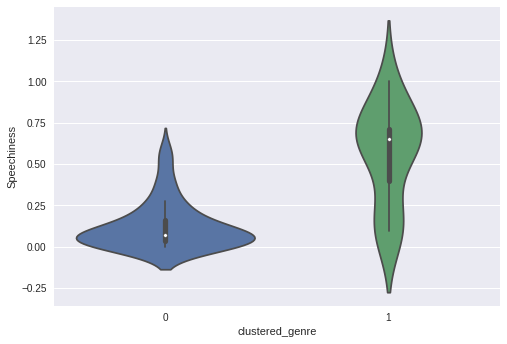

In [31]:
sns.violinplot(data=scaled_top50_df, y= 'Speechiness', x ='clustered_genre')

<AxesSubplot:xlabel='clustered_genre', ylabel='Popularity'>

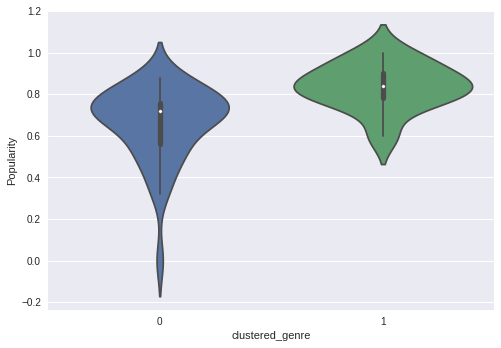

In [32]:
sns.violinplot(data=scaled_top50_df, y= 'Popularity', x ='clustered_genre')

Based off of our clustering, we can determine cluster 1 tends to be more popular than cluster 0. Furthermore:
    
<b> Cluster 1 characteristics: </b>

   - Higher speechiness 
   - Higher Acousticness 
   - Shorter song Length
   - More Beats per Minute
   - Sadder (Lower Valence)

when compared to cluster 0

### If we take a look at this new feature we have added:

In [33]:
scaled_top50_df[['Popularity', 'clustered_genre']].corr()

,Popularity,clustered_genre
Popularity,1.000000,0.407192
clustered_genre,0.407192,1.000000


We see it has a strong positive correlation with Popularity. We will include this in our model.

## 2. Determine if any correlation exists between features.

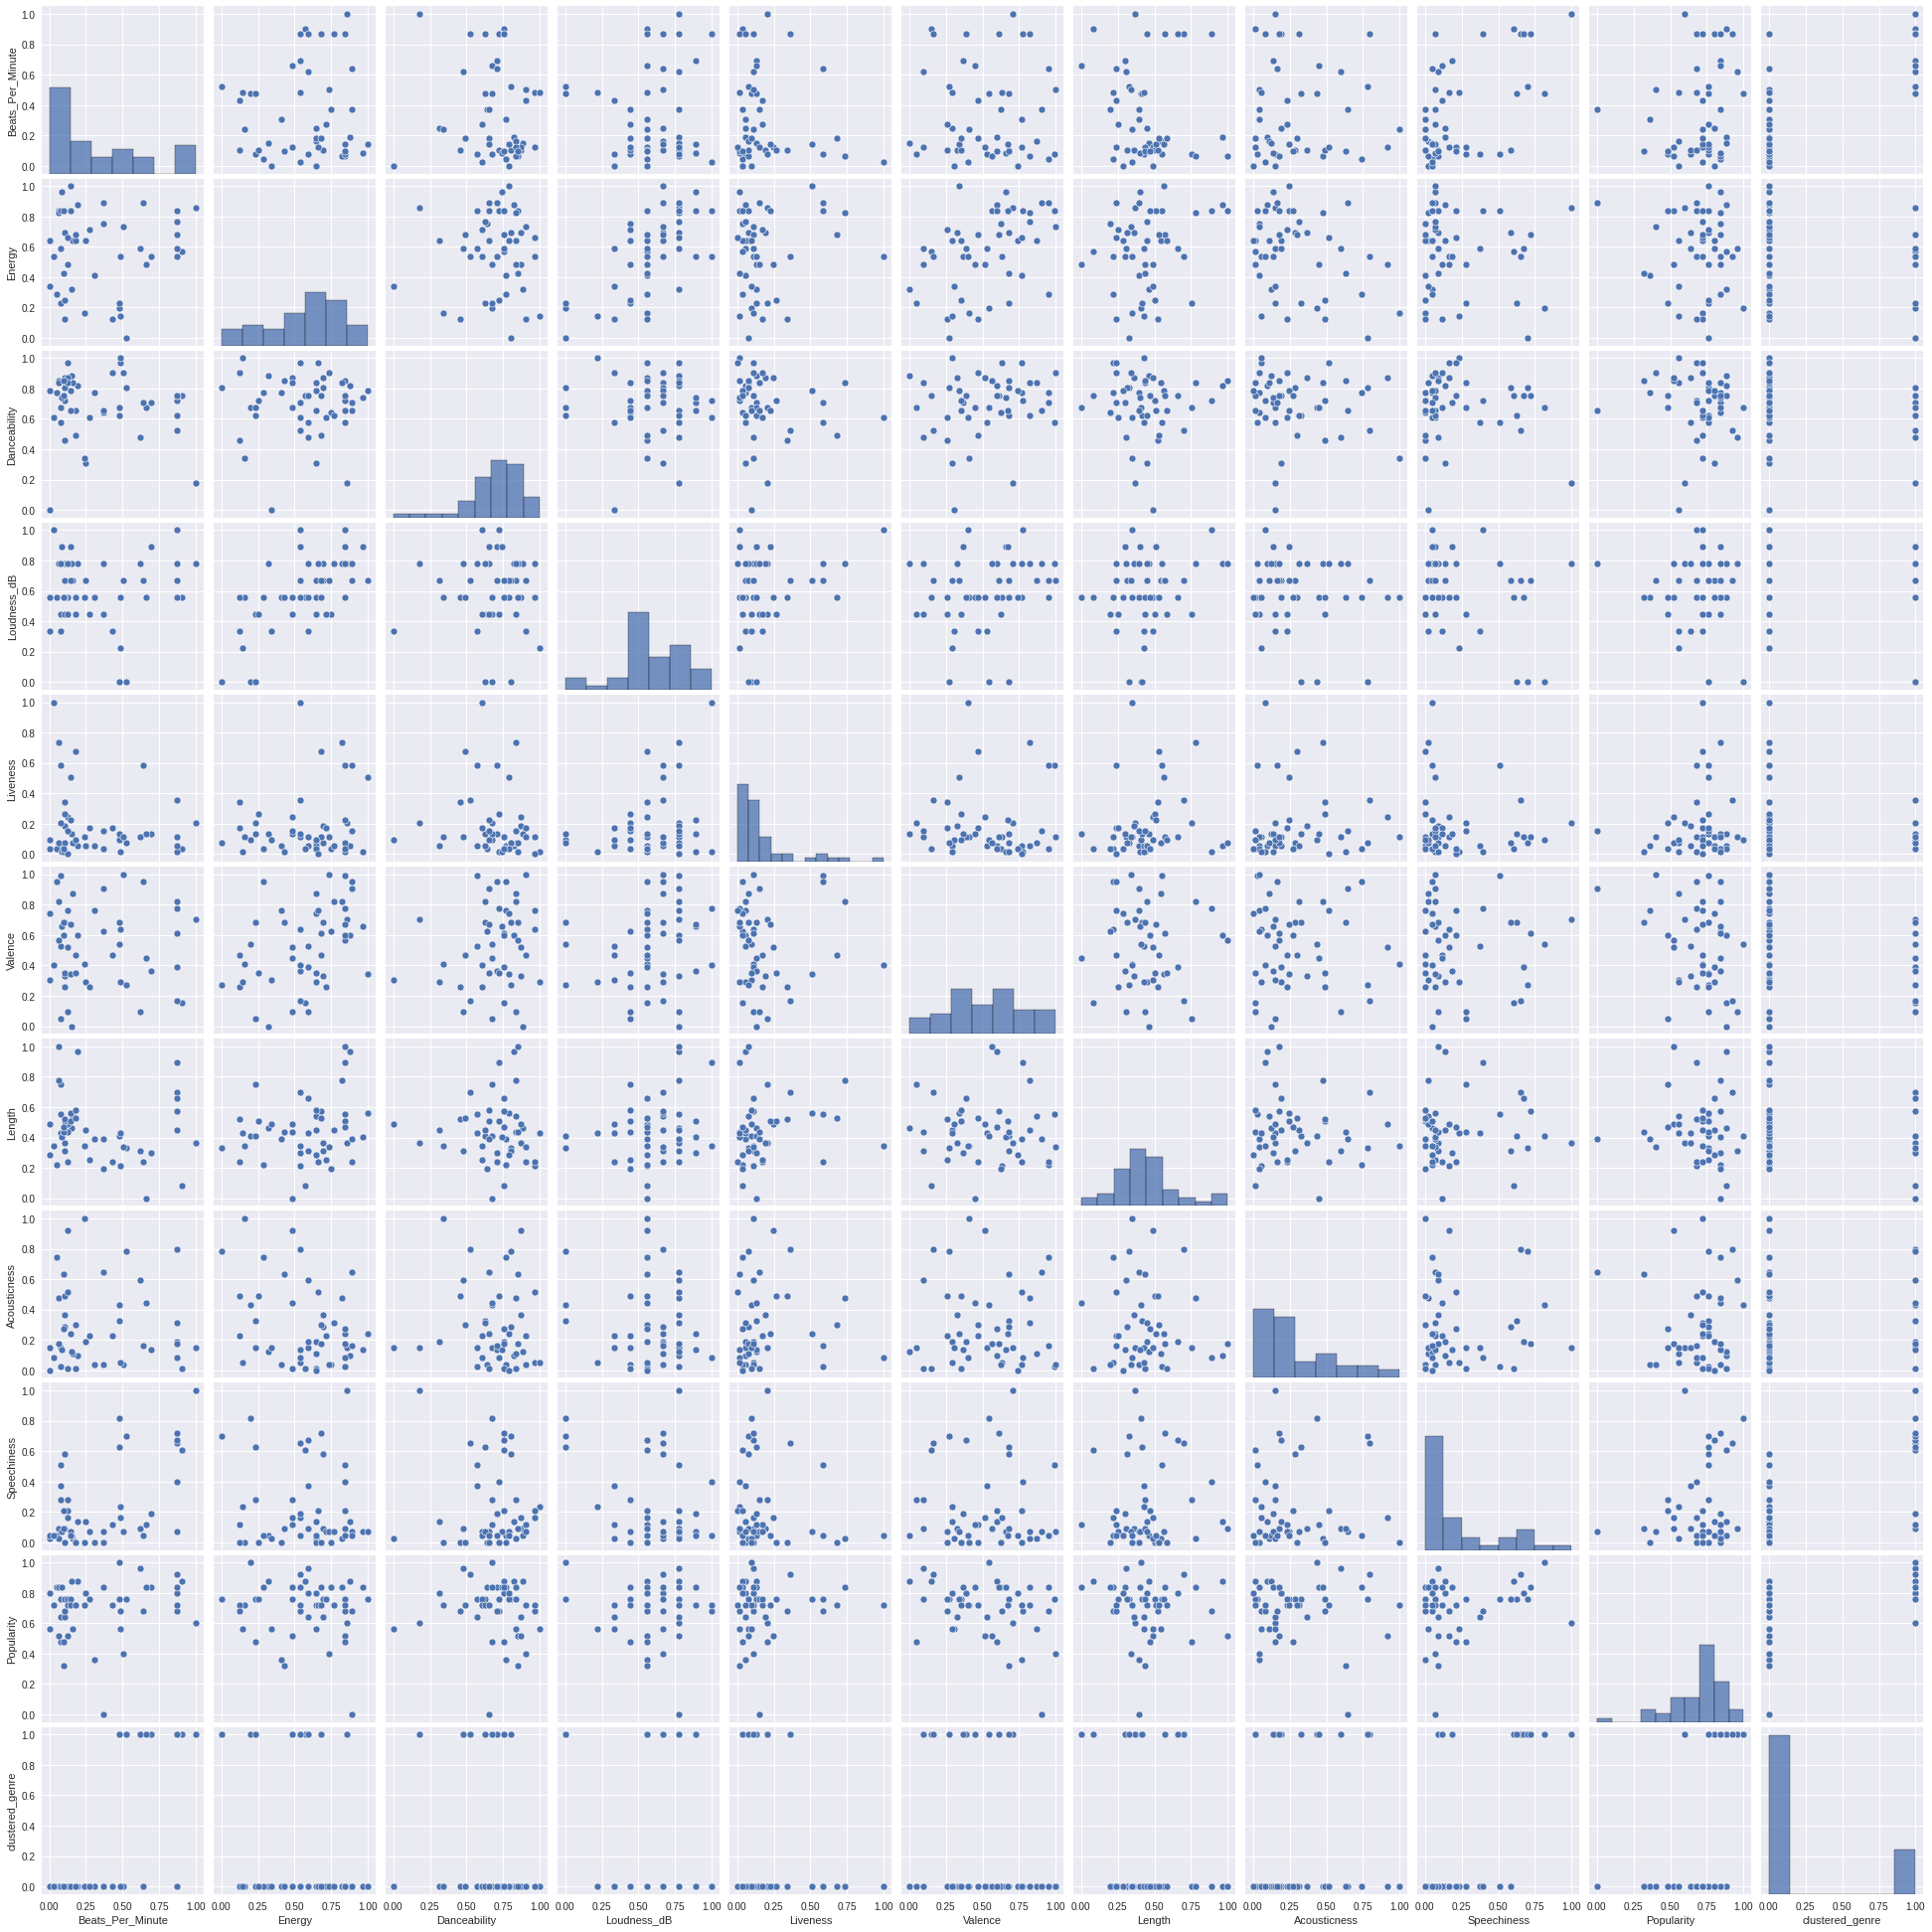

In [34]:
sns.pairplot(scaled_top50_df)
plt.show()

When we visually inspect our pairwise correlation splots, no obvious correlations appear. We may also look at the pairwise pearson correlation coefficients to see if we notice anything else.

In [35]:
scaled_top50_df.corr()

,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,clustered_genre
Beats_Per_Minute,1.000000,0.043756,-0.094183,0.017016,-0.167286,-0.011586,-0.139288,-0.031450,0.557052,0.196097,0.709247
Energy,0.043756,1.000000,0.018254,0.670794,0.162768,0.438820,0.224677,-0.339892,-0.089860,-0.080295,-0.197592
Danceability,-0.094183,0.018254,1.000000,0.016255,-0.149636,0.172829,-0.000185,-0.098165,-0.103472,-0.071413,-0.180613
Loudness_dB,0.017016,0.670794,0.016255,1.000000,0.258652,0.237614,0.219219,-0.138300,-0.272213,-0.043085,-0.230993
Liveness,-0.167286,0.162768,-0.149636,0.258652,1.000000,0.016123,0.131782,0.021328,-0.125286,0.092564,-0.115190
Valence,-0.011586,0.438820,0.172829,0.237614,0.016123,1.000000,-0.017782,-0.052323,-0.053242,-0.317752,-0.250229
Length,-0.139288,0.224677,-0.000185,0.219219,0.131782,-0.017782,1.000000,-0.076293,0.046755,-0.087639,-0.177620
Acousticness,-0.031450,-0.339892,-0.098165,-0.138300,0.021328,-0.052323,-0.076293,1.000000,0.008293,-0.034684,0.170070
Speechiness,0.557052,-0.089860,-0.103472,-0.272213,-0.125286,-0.053242,0.046755,0.008293,1.000000,0.238553,0.706636
Popularity,0.196097,-0.080295,-0.071413,-0.043085,0.092564,-0.317752,-0.087639,-0.034684,0.238553,1.000000,0.407192


Our correlations are still modest, but there does seem to be a moderate positive correlation between Beats per Minute and Speechiness (r = 0.56), and loudness and energy (r = 0.67). The latter makes sense because songs that have a lot of energy are unlikely to be quiet. And the former may be described by rap which typically has high speechiness and faster beats per minute (to verify)

If we consider our newly added feature, we see that beats per minute and clustered genre have a high correlation (r = 0.70) as well as speechiness and clustered genre (r = 0.70).

## 3. Check for outliers in Popularity

<AxesSubplot:>

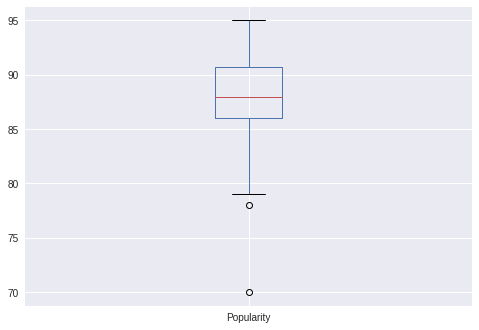

In [36]:
top50_df.boxplot(column=['Popularity'])

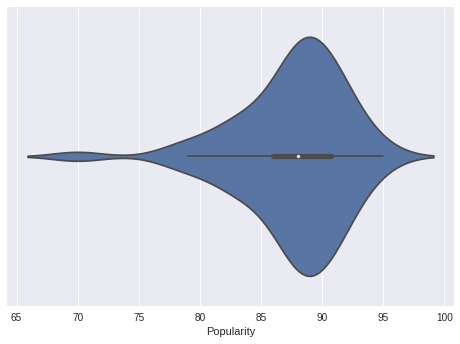

In [37]:
ax = sns.violinplot(x=top50_df["Popularity"])

The distribution for popularity has a left skew due to our outlier popularity scores of 70 and 78. Let's examine which songs those are. 

In [38]:
top50_df[top50_df.Popularity <= 78]

,Track_Name,Artist_Name,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
26,If I Can't Have You,Shawn Mendes,canadian pop,124,82,69,-4,13,87,191,49,6,70
40,"fuck, i'm lonely (with Anne-Marie) - from “13 ...",Lauv,dance pop,95,56,81,-6,6,68,199,48,7,78


In [39]:
scaled_top50_df.iloc[[25,39],:]

,Track_Name,Artist_Name,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,clustered_genre
25,If I Can't Have You,Shawn Mendes,canadian pop,0.371429,0.892857,0.655738,0.777778,0.150943,0.905882,0.391753,0.648649,0.069767,0.00,0
39,"fuck, i'm lonely (with Anne-Marie) - from “13 ...",Lauv,dance pop,0.095238,0.428571,0.852459,0.555556,0.018868,0.682353,0.432990,0.635135,0.093023,0.32,0


Unsurprisingly, these songs both belong to cluster 0, which on average has a lower popularity score than cluster 1. 

## 4. Time to fit the model

In [40]:
# Prep the data
X = scaled_top50_df.drop(['Track_Name','Artist_Name','Genre', 'Popularity'], axis = 1)
y = scaled_top50_df.Popularity**2 # Square our y to take care of left skew

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [41]:
reg = LinearRegression().fit(X_train, y_train)

In [42]:
reg_train_mse = mean_squared_error(y_train,
                                    reg.predict(X_train))
reg_train_rsq = reg.score(X_train, y_train)

In [43]:
reg_test_mse = mean_squared_error(y_test,
                                    reg.predict(X_test))
reg_test_rsq = reg.score(X_test, y_test)

In [44]:
print(f"Train MSE: {reg_train_mse}")
print(f"Train Rsq: {reg_train_rsq}")
print(f"Test MSE: {reg_test_mse}")
print(f"Test Rsq: {reg_test_rsq}")

Train MSE: 0.02884249800631205
Train Rsq: 0.30482988379709663
Test MSE: 0.04473679892222803
Test Rsq: 0.18029246834764334


Overall, we find that our MSE appears to be fairly small, but our low R-squared values suggest that a linear model may not be appropriate if we want to predict the exact popularity score. When we examined the correlations between variables earlier, we found that none of the variables were very highly correlated with song popularity. Furthermore, since we are already looking at the top 50, we've already separated out the most popular group, therefore we do not have the data for what an unpopular song would look like. 

But what if we turned this into a classification problem instead? We can do this by splitting the scores to above the median vs. below the median, meaning above average popularity (y=1) and below average popularity (y=0). We are still working with the group of popular songs, but we can create a cut off this way. 

In [45]:
median_popularity = scaled_top50_df.Popularity.median()
print(f"Median popularity score = {round(median_popularity,2)}")

Median popularity score = 0.72


In [46]:
# Create a indicator column where the indicator = 1 when we are above average popularity and 0 otherwise.

scaled_top50_df['Above_avg_popularity'] = 0
gt_avg_idx = scaled_top50_df[scaled_top50_df.Popularity > median_popularity].index
scaled_top50_df.iloc[gt_avg_idx,-1] = 1

In [47]:
scaled_top50_df.head()

,Track_Name,Artist_Name,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,clustered_genre,Above_avg_popularity
0,Señorita,Shawn Mendes,canadian pop,0.304762,0.410714,0.770492,0.555556,0.056604,0.764706,0.391753,0.040541,0.000000,0.36,0,0
1,China,Anuel AA,reggaeton flow,0.190476,0.875000,0.819672,0.777778,0.056604,0.600000,0.963918,0.094595,0.139535,0.88,0,1
2,boyfriend (with Social House),Ariana Grande,dance pop,1.000000,0.857143,0.180328,0.777778,0.207547,0.705882,0.365979,0.148649,1.000000,0.60,1,0
3,Beautiful People (feat. Khalid),Ed Sheeran,pop,0.076190,0.589286,0.573770,0.333333,0.056604,0.529412,0.427835,0.148649,0.372093,0.64,0,0
4,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,0.619048,0.589286,0.475410,0.777778,0.113208,0.094118,0.309278,0.594595,0.093023,0.96,1,1


In [48]:
# Prep the data for fit 

X= scaled_top50_df.drop(['Track_Name','Artist_Name','Genre', 'Popularity', 'Above_avg_popularity'], axis = 1)
y= scaled_top50_df.Above_avg_popularity 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [49]:
# Fit a logistic regression model

logReg = LogisticRegression(random_state=0).fit(X_train, y_train)

In [50]:
logReg_train_mse = mean_squared_error(y_train,
                                    logReg.predict(X_train))
logReg_test_mse = mean_squared_error(y_test,
                                    logReg.predict(X_test))
logReg_train_AUC = logReg.score(X_train, y_train)
logReg_test_AUC = logReg.score(X_test, y_test)

In [51]:
print(f"Train MSE: {logReg_train_mse}")
print(f"Test MSE: {logReg_test_mse}")
print(f"Train AUC: {logReg_train_AUC}")
print(f"Test AUC: {logReg_test_AUC}")

Train MSE: 0.275
Test MSE: 0.4
Train AUC: 0.725
Test AUC: 0.6


We find that even in the context of a classification problem, predicting song popularity appears to be difficult. 